## Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os
import gdown
from sklearn.model_selection import train_test_split
import splitfolders
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [2]:
# Download the dataset from Google Drive
url = 'https://drive.google.com/uc?id=1MvZQi2ndOsk6CYqSU0PBFrMRJK2STSwx'
output = 'HAR_Images.zip'
gdown.download(url, output, quiet=False)

# Unzip the dataset
import zipfile
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('.') # extracts into current directory

Downloading...
From (original): https://drive.google.com/uc?id=1MvZQi2ndOsk6CYqSU0PBFrMRJK2STSwx
From (redirected): https://drive.google.com/uc?id=1MvZQi2ndOsk6CYqSU0PBFrMRJK2STSwx&confirm=t&uuid=8f201086-5436-407c-a429-8a36ffcead1a
To: c:\Users\Personal\OneDrive\Desktop\Machine_Learning_Implementations\deep_learning\HAR_Images.zip
100%|██████████| 13.2M/13.2M [00:05<00:00, 2.48MB/s]


## Set device-agnostic code

In [3]:
# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

## Prepare train and test sets, loaders
We're going to take advantage of a built-in torchvision dataset tool called <a href='https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder'><tt><strong>ImageFolder</strong></tt></a>.

In [5]:
path = f"{os.getcwd()}\\HAR_Images"

In [6]:
splitfolders.ratio(path, output="output",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False) # default values

Copying files: 5058 files [00:27, 187.31 files/s]


In [7]:
train_path = f"{os.getcwd()}\\output\\train"
val_path = f"{os.getcwd()}\\output\\val"

In [8]:
train_data = datasets.ImageFolder(train_path, transform = transform)
test_data = datasets.ImageFolder(val_path, transform = transform)

In [9]:
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size = 32, shuffle=True,  drop_last = True)
test_loader = DataLoader(test_data, batch_size= 32,  drop_last = True)

class_names = train_data.classes # classes or labels or categories

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['Catch', 'Clap', 'Hammering']
Training images available: 4044
Testing images available:  1014


## Display a batch of images

In [10]:

for images,labels in train_loader:
    break
images.shape



torch.Size([32, 3, 64, 64])

In [11]:
labels

tensor([1, 2, 1, 1, 2, 1, 2, 2, 0, 0, 2, 2, 1, 0, 0, 1, 2, 2, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 2, 2, 0, 2])

Label: [1 2 1 1 2 1 2 2 0 0 2 2 1 0 0 1 2 2 1 1 1 1 0 1 1 0 0 0 2 2 0 2]
Class: Clap Hammering Clap Clap Hammering Clap Hammering Hammering Catch Catch Hammering Hammering Clap Catch Catch Clap Hammering Hammering Clap Clap Clap Clap Catch Clap Clap Catch Catch Catch Hammering Hammering Catch Hammering


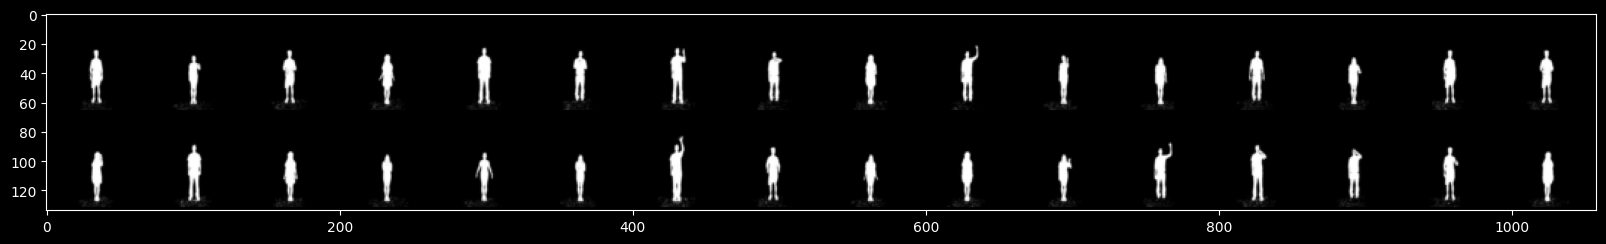

In [12]:
# Print the labels

print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=16)  # 5 images in a row. the default nrow is 8


# Print the images

plt.figure(figsize=(20,16))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Define the model

In [13]:
model = nn.Sequential(
          nn.Linear(12288,2048),  # 3 x 64 x 64 = 12288
          nn.ReLU(),
          nn.Linear(2048,2048),
          nn.ReLU(),
          nn.Linear(2048,1024),
          nn.ReLU(),
          nn.Linear(1024,512),
          nn.ReLU(),
          nn.Linear(512,256),
          nn.ReLU(),
          nn.Linear(256,128),
          nn.ReLU(),
          nn.Linear(128,64),
          nn.ReLU(),
          nn.Linear(64,32),
          nn.ReLU(),
          nn.Linear(32,3),
          )
model

Sequential(
  (0): Linear(in_features=12288, out_features=2048, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2048, out_features=2048, bias=True)
  (3): ReLU()
  (4): Linear(in_features=2048, out_features=1024, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=512, bias=True)
  (7): ReLU()
  (8): Linear(in_features=512, out_features=256, bias=True)
  (9): ReLU()
  (10): Linear(in_features=256, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=64, bias=True)
  (13): ReLU()
  (14): Linear(in_features=64, out_features=32, bias=True)
  (15): ReLU()
  (16): Linear(in_features=32, out_features=3, bias=True)
)

## Train the model

In [14]:
from tqdm.auto import tqdm
numepochs = 50
# loss function
lossfun = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(),momentum = 0.9, lr = 0.01)

# initialize losses
losses = torch.zeros(numepochs)
trainAcc = []
testAcc = []


  # loop over epochs
for epochi in tqdm(range(numepochs)):
    # loop over training data batches
    model.train()
    model.to(device)
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:
      X = X.reshape(32,12288)
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat =  model(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      yHat = yHat.cpu()
      y = y.cpu()

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    print(f'epoch: {epochi}   loss: {loss.item()}')
      # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy


    model.eval()
    with torch.no_grad():

        for X,y in test_loader:
        #X,y = next(iter(test_loader)) # extract X,y from test dataloader

            X = X.reshape(32,12288)
            X = X.to(device)
            y = y.to(device)

            yHat =  model(X)

        # bring outputs back
            yHat = yHat.cpu()
            y = y.cpu()

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs



  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 0   loss: 1.1056097745895386
epoch: 1   loss: 1.1036255359649658
epoch: 2   loss: 1.0878926515579224
epoch: 3   loss: 1.0980197191238403
epoch: 4   loss: 1.1024032831192017
epoch: 5   loss: 1.1227831840515137
epoch: 6   loss: 1.0898274183273315
epoch: 7   loss: 1.0991712808609009
epoch: 8   loss: 1.0861101150512695
epoch: 9   loss: 1.1094292402267456
epoch: 10   loss: 1.1085513830184937
epoch: 11   loss: 1.0967472791671753
epoch: 12   loss: 1.1041406393051147
epoch: 13   loss: 1.1162699460983276
epoch: 14   loss: 1.0952887535095215
epoch: 15   loss: 1.1016842126846313
epoch: 16   loss: 1.0911120176315308
epoch: 17   loss: 1.0863016843795776
epoch: 18   loss: 1.0731451511383057
epoch: 19   loss: 0.6789820194244385
epoch: 20   loss: 0.5255522131919861
epoch: 21   loss: 0.517439603805542
epoch: 22   loss: 0.2672053873538971
epoch: 23   loss: 0.3947868347167969
epoch: 24   loss: 0.26977670192718506
epoch: 25   loss: 0.18094931542873383
epoch: 26   loss: 0.3411276936531067
epoch: 27 

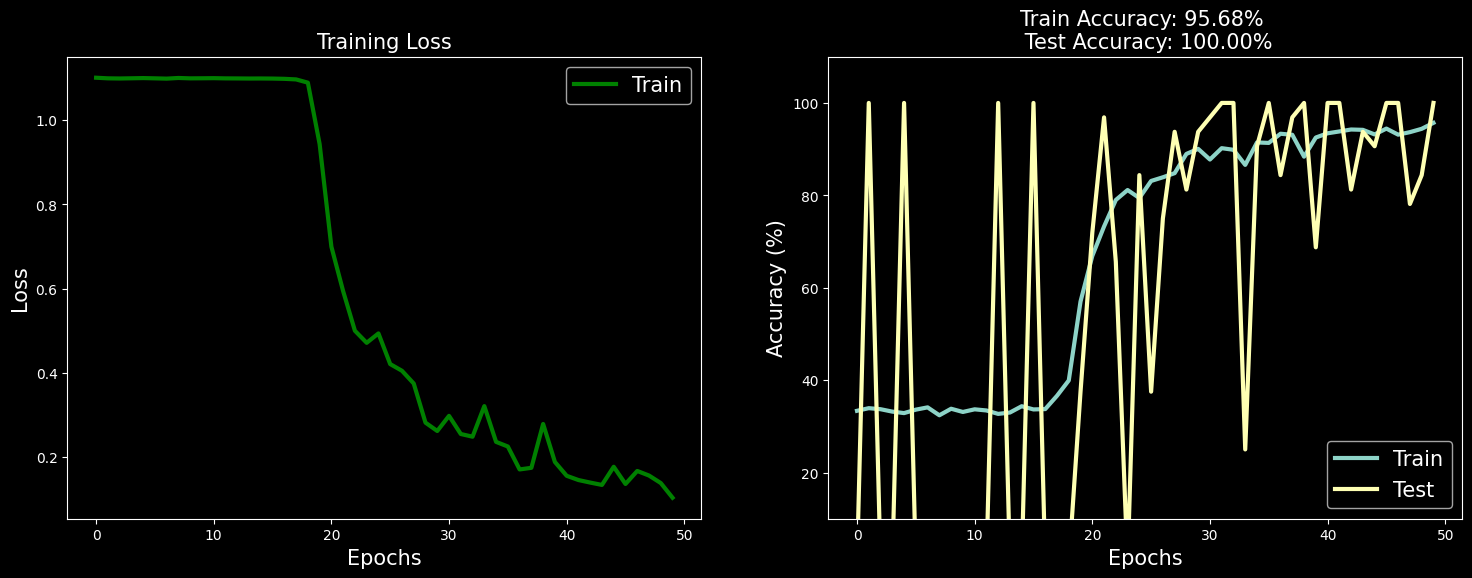

In [15]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()